## Building Flexible Audio DDSP Pipelines: A Case Study on Artificial Reverb
**DAFx25 Tutorial - September 2, 2025**  
*International Conference on Digital Audio Effects DAFx, Ancona (IT)*

### Loss Landscape Visualization for FDN Parameter Optimization

This notebook demonstrates how to visualize the loss landscape of FDN parameters to understand the optimization behavior.

In [7]:
# --- Imports ---
import numpy as np
import soundfile as sf 
import torch

from ddsp.utils import *
from ddsp.fdn import BaseFDN
from ddsp.loss import *

import flamo.processor.dsp as dsp
from flamo.functional import skew_matrix
from flamo.auxiliary.reverb import HomogeneousFDN, map_gamma, inverse_map_gamma
from flamo.optimize.loss import mse_loss
from flamo.optimize.surface import LossProfile, LossConfig, ParameterConfig, LossSurface
from flamo.functional import signal_gallery, get_magnitude

# --- Device Configuration ---
torch.set_default_dtype(torch.float32)
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cpu


### FDN Configuration and Loss Landscape Setup

Configure the FDN parameters and define the parameter space for loss landscape visualization:
- Set up audio parameters (sampling rate, FFT size)
- Generate coprime delays for the FDN
- Define parameter configurations for landscape exploration
- Set up loss functions and analysis configuration

In [ ]:
# --- Audio Configuration ---
fs = 48000      # Sampling rate
nfft = 2 * fs   # FFT size
alias_decay_db = 0      # desired decay for time aliasing mitigation (in dB)
N = 4           # Number of delay lines in the FDN

# --- FDN Delay Configuration ---
# Generate random coprime delays to avoid unwanted resonances
delays = find_coprime_numbers(500, 1500, N, 6000)
print(f"Generated delays: {delays}")

# --- Parameter Configurations for Loss Landscape ---
# Define two different parameter configurations to explore
param_config = [
    ParameterConfig(
        key="feedback_loop.feedback.attenuation",
        lower_bound=0.25,
        upper_bound=3.75,
        target_value=2,
        scale="linear",
        n_steps=10,
        indx=0,  # First attenuation parameter - RT at DC
    ),
    ParameterConfig(
        key='feedback_loop.feedback.attenuation',
        lower_bound=0.131,
        upper_bound=2.094,
        target_value=0.5236,
        scale='linear',
        n_steps=10,
        indx=1  # Second attenuation parameter - cutoff frequency
    )]

# --- Loss Functions Configuration ---
# Define loss functions to evaluate in the landscape
criteria = [
    mss_loss(name='MSS', alpha=0),  # Multiscale Spectral loss
    edr_loss(name="EDR", energy_norm=True),  # Energy Decay Relief loss
]

# --- Loss Configuration ---
# Configure the loss landscape analysis
loss_config = LossConfig(
    criteria=criteria,
    param_config=[param_config[1]],  # Start with second parameter - cutoff frequency
    perturb_param="feedback_loop.feedback.mixing_matrix",  # Parameter to perturb
    n_runs=10,  # Number of runs/perturbations
    perturb_map=lambda x: x,  # Identity mapping (no transformation)
    output_dir="../../data/results/loss_landscape",  # Output directory for results
)


Generated delays: [887, 1109, 1471, 1951]


### Target Signal Loading and Visualization

Load the target signal that we want our FDN to match and visualize its spectral characteristics.

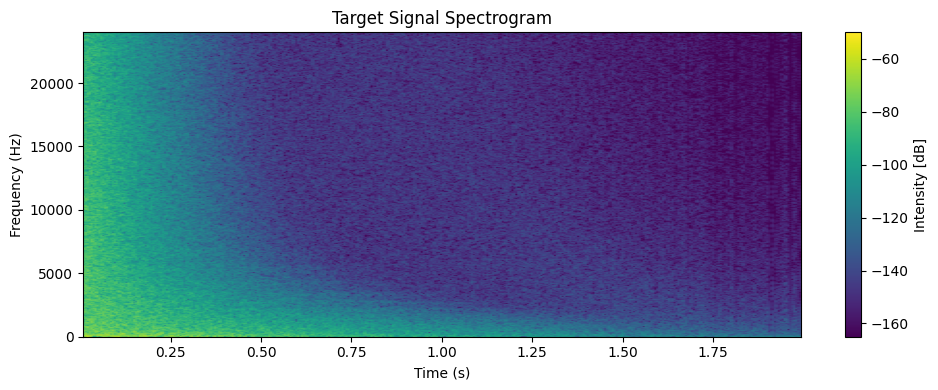

Target signal shape: torch.Size([96000])
Target signal duration: 2.00 seconds


In [9]:
# --- Load Target Signal ---
# Load the target signal that our FDN should match
target_signal = torch.tensor(sf.read('../../data/target_signal.wav')[0], dtype=torch.float32)

# --- Visualize Target Signal ---
# Plot spectrogram to understand the spectral characteristics of the target
plot_spectrogram(target_signal, fs, title='Target Signal Spectrogram', clim=[-50, -150])
print(f"Target signal shape: {target_signal.shape}")
print(f"Target signal duration: {len(target_signal)/fs:.2f} seconds")

### FDN Model Creation and Target Matching

Create the differentiable FDN model and configure it to match the target signal:
- Initialize the FDN with the configured parameters
- Set attenuation values to the target response
- Normalize energy to match target signal or use self-target mode
- Visualize the resulting impulse response

Set attenuation values: [2.0, 0.5236]
Using self-target mode: FDN response as target


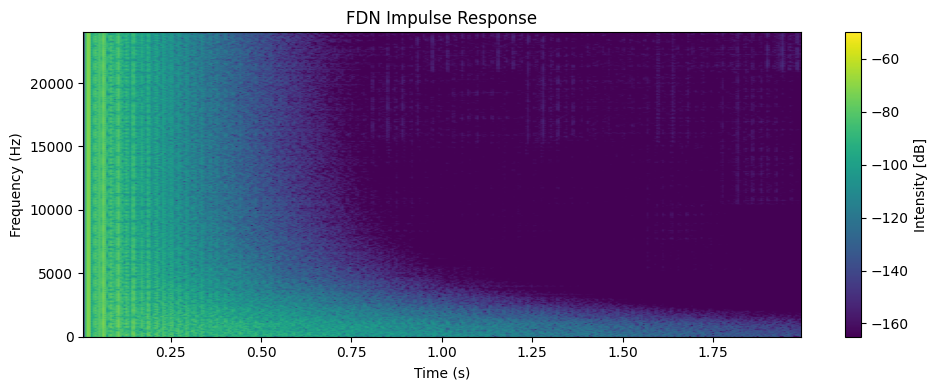

In [10]:
# --- Create FDN Model ---
# Initialize a homogeneous FDN model with lowpass attenuation
fdn = BaseFDN(
    N=N,                           # Number of delay lines
    fs=fs,                         # Sampling rate
    nfft=nfft,                     # FFT size for frequency domain processing
    delay_lengths=delays,          # Delay line lengths
    alias_decay_db=alias_decay_db, # Time aliasing mitigation
    device=device,                 # Computation device
    attenuation_type="lowpass",    # Type of attenuation filter
)

# --- Set Attenuation Parameters ---
# Configure the attenuation values from our parameter configuration
fdn.set_attenuation(torch.tensor([param_config[0].target_value, param_config[1].target_value]))
print(f"Set attenuation values: [{param_config[0].target_value}, {param_config[1].target_value}]")

# --- Target Signal Configuration ---
# Choose between self-target mode or external target matching
is_self_target = True 
if is_self_target:
    # Use the FDN's own response as target (for landscape analysis)
    target_signal = fdn.shell.get_time_response()
    print("Using self-target mode: FDN response as target")
else:
    # Match energy to external target signal
    target_energy = torch.mean(torch.pow(torch.abs(torch.fft.rfft(target_signal)), 2))
    fdn.normalize_energy(target_energy=target_energy)
    target_signal = target_signal.to(device).unsqueeze(0).unsqueeze(-1)
    print("Using external target with energy normalization")

# --- Visualize FDN Response ---
# Get and plot the impulse response of the configured FDN
ir_fdn = fdn.shell.get_time_response()
plot_spectrogram(ir_fdn.squeeze(), fs=fs, title='FDN Impulse Response', clim=[-50, -150])


### Loss Profile Analysis (1D)

Analyze the loss profile along a single parameter dimension to understand the optimization landscape:
- Create an impulse input signal for analysis
- Configure loss analysis for both parameter configurations
- Compute and visualize the 1D loss profile

Input signal shape: torch.Size([1, 96000, 1])


Run: 100%|██████████| 1/1 [00:03<00:00,  3.97s/it]


NameError: name 's' is not defined

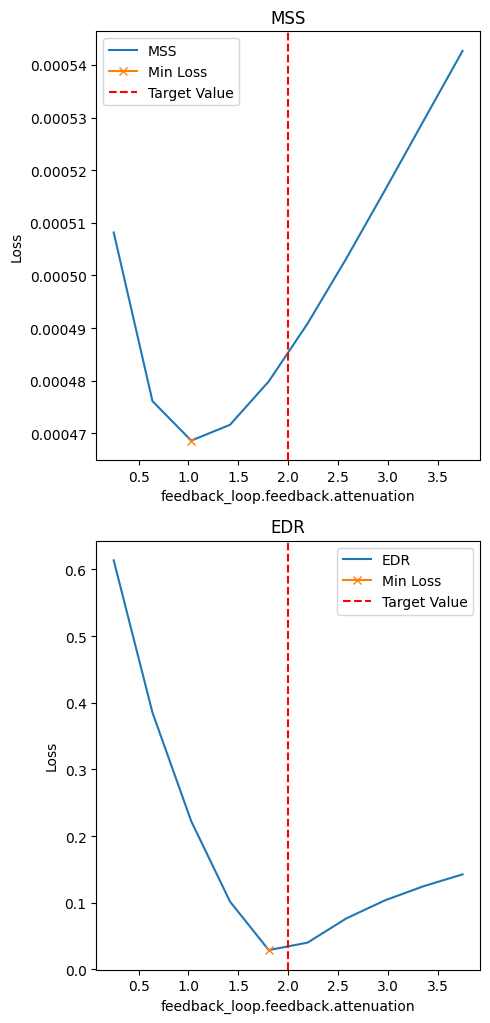

In [11]:
# --- Create Input Signal ---
# Generate an impulse signal for loss landscape analysis
input_signal = signal_gallery(
    signal_type="impulse",     # Use impulse for system analysis
    batch_size=1,              # Single batch
    n_samples=nfft,            # Match FFT size
    n=1,                       # Single impulse
    fs=fs,                     # Sample rate
    device=device,             # Computation device
)
print(f"Input signal shape: {input_signal.shape}")

# --- Configure Loss Analysis ---
# Set up loss configuration for all parameter configurations
loss_config.param_config = param_config  # Use both parameter configs
loss_config.n_runs = 1                   # Single run for speed

# --- Compute and Plot 1D Loss Profile ---
# Create loss profile analyzer and compute loss along parameter dimension
loss_surface = LossProfile(fdn.shell, loss_config)
loss_values = loss_surface.compute_loss(input_signal, target_signal)
loss_surface.plot_loss(loss_values)
s

### Loss Surface Analysis (2D)

Analyze the 2D loss surface to understand parameter interactions and optimization challenges:
- Use the same parameter configurations for 2D analysis
- Compute and visualize the full 2D loss landscape
- Identify local minima, saddle points, and convergence basins

Loss for the criterion MSS: 0.0013133177999407053
Loss for the criterion EDR: 0.1512724757194519


Run: 100%|██████████| 1/1 [00:38<00:00, 38.93s/it]


(<Figure size 1000x3000 with 3 Axes>,
 array([<Axes3D: title={'center': 'MSS'}, xlabel='feedback_loop.feedback.attenuation', ylabel='feedback_loop.feedback.attenuation', zlabel='Loss'>,
        <Axes3D: title={'center': 'EDR'}, xlabel='feedback_loop.feedback.attenuation', ylabel='feedback_loop.feedback.attenuation', zlabel='Loss'>,
        <Axes3D: >], dtype=object))

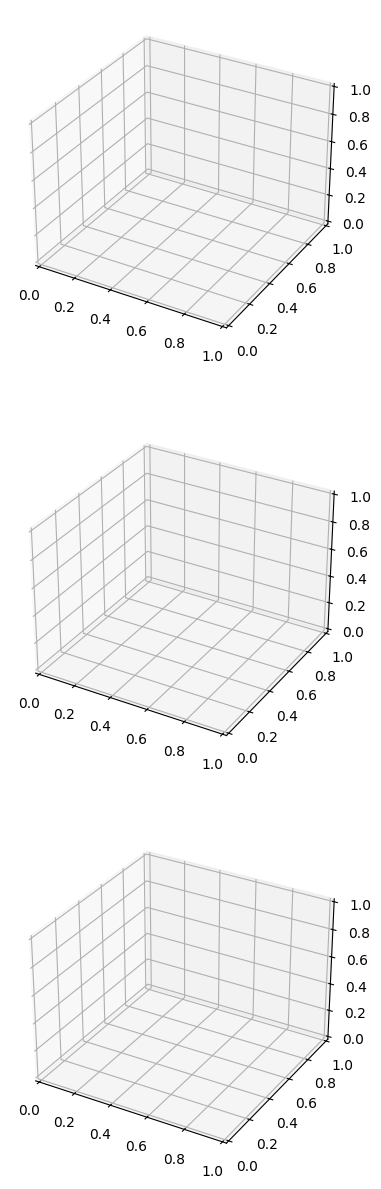

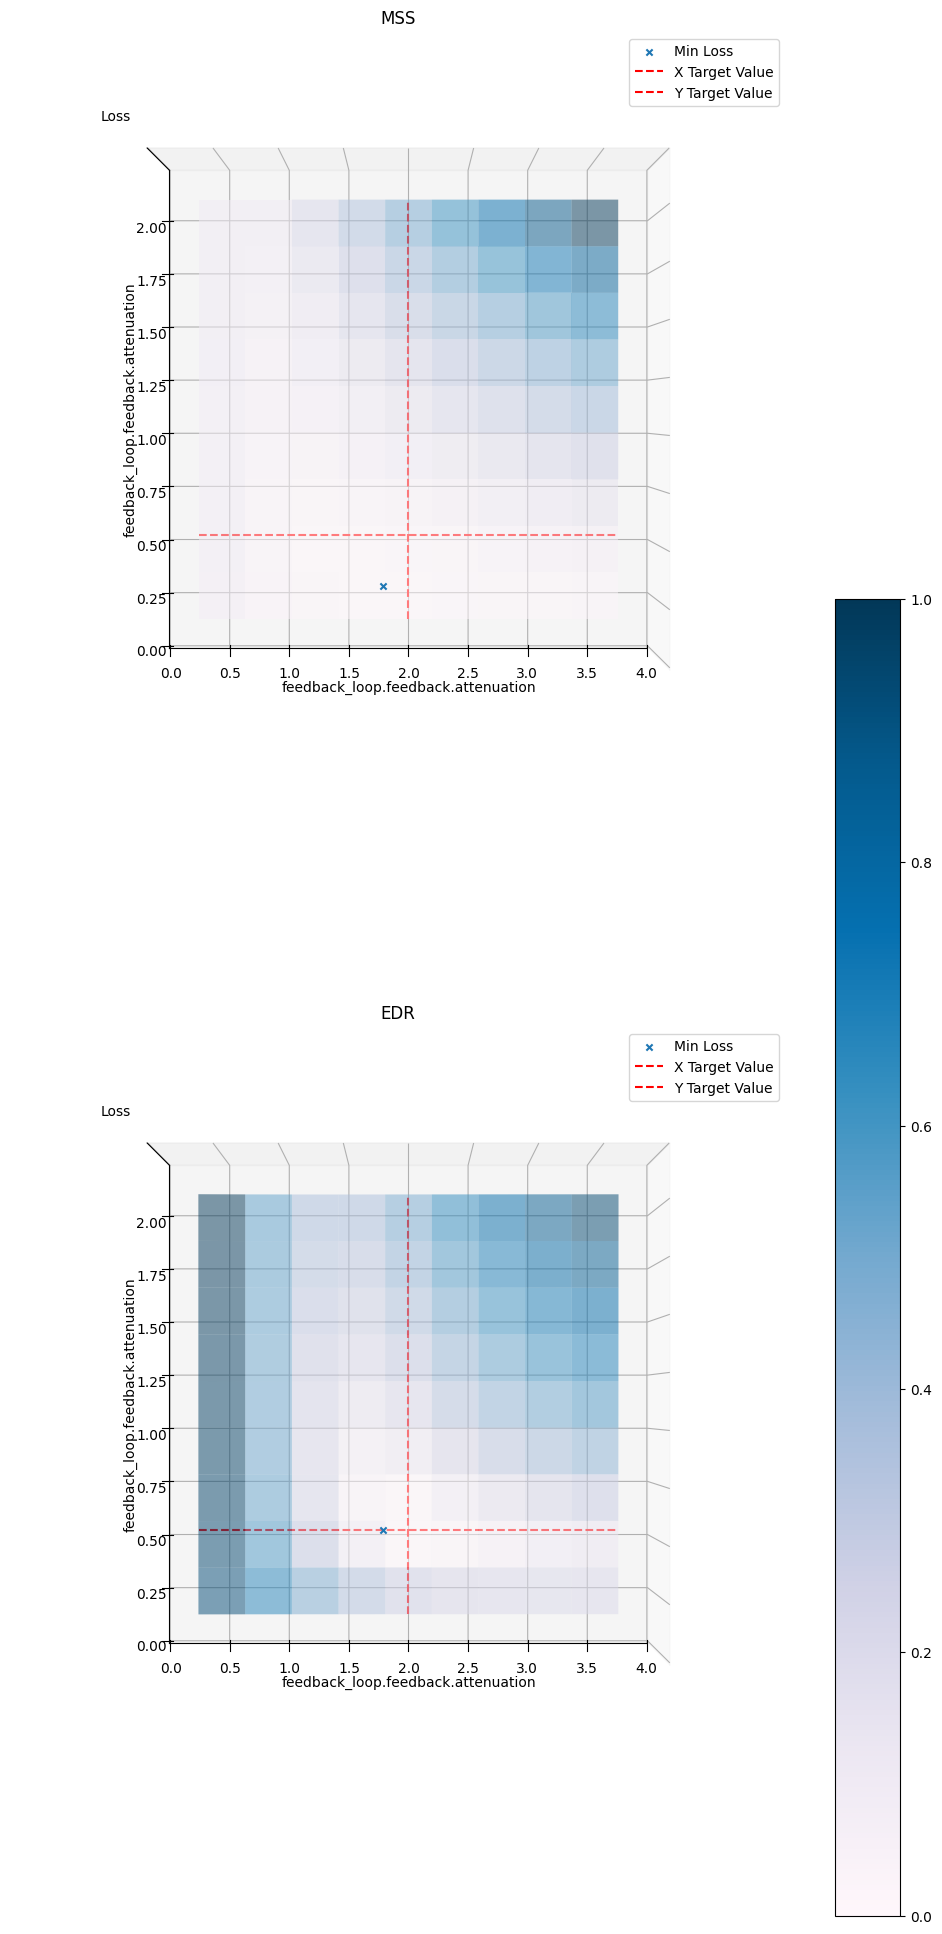

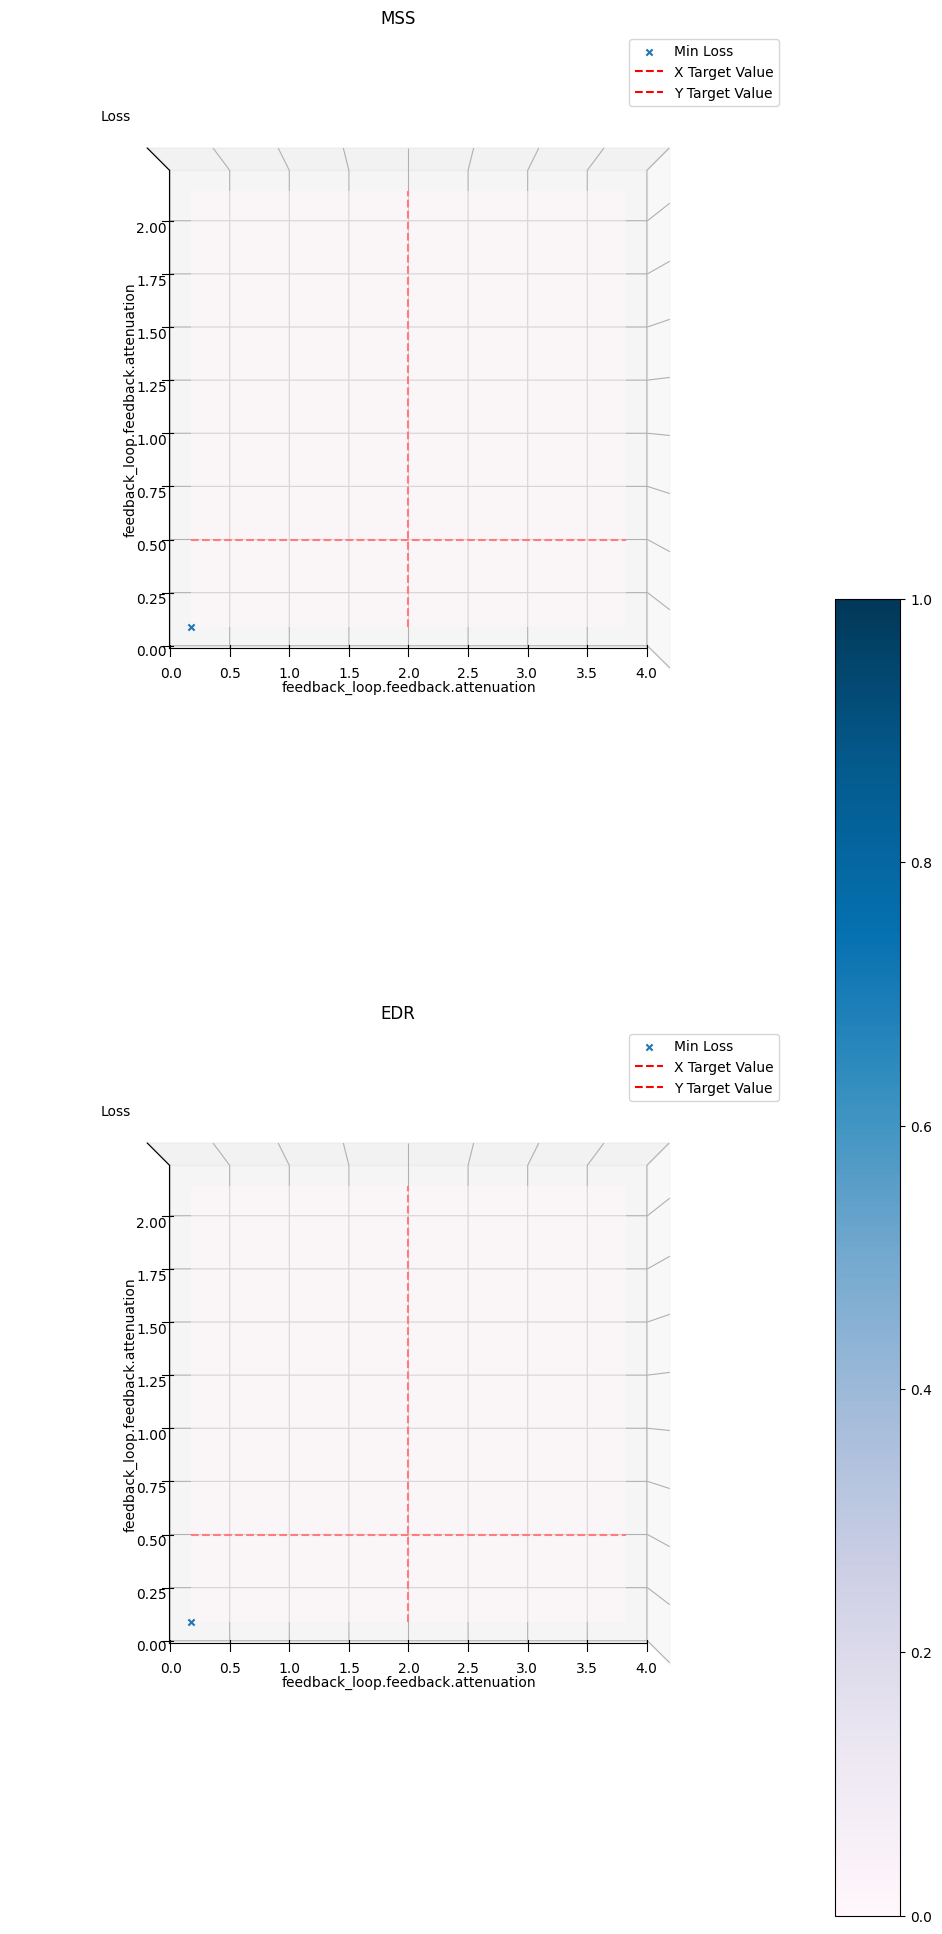

In [ ]:
# --- Configure 2D Loss Surface Analysis ---
# Use both parameter configurations for 2D surface analysis
loss_config.param_config = param_config  # Both parameter dimensions
loss_config.n_runs = 1                   # Single run 

# --- Compute and Plot 2D Loss Surface ---
# Create 2D loss surface analyzer and compute the full landscape
loss_surface = LossSurface(fdn.shell, loss_config)
loss_values_2d = loss_surface.compute_loss(input_signal, target_signal)

# loss_surface.plot_loss(loss_values_2d)

